In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("train_imperson_without4n7_balanced_data.csv")

Delete columns that have zero variance

In [3]:
col_to_delete = [k for k in train.columns if train[k].std()==0]

Of which there are

In [4]:
len(col_to_delete)

74

In [5]:
train = train.drop(col_to_delete,axis=1)

Build a data table to hold information regarding the remaining variables

(Some `pandas` operations are easier if the factor name is a regular column but it's nice for that to be the index too)

In [45]:
factors = pd.DataFrame(data = train.columns[:-1], columns = ['factor'], index = train.columns[:-1])

In [46]:
factors["mu"] = factors.factor.apply(lambda f: train[f].mean())

factors["sigma"] = factors.factor.apply(lambda f: train[f].std())

factors["rho"] = factors.factor.apply(lambda f: train[f].corr(train["155"]))

factors.head()

,factor,mu,sigma,rho
5,5,0.006252,0.015541,0.058410
6,6,0.006252,0.015541,0.058410
8,8,0.193837,0.354444,-0.438183
9,9,0.193837,0.354444,-0.438183
14,14,0.999784,0.014709,0.014712


Conduct t-tests to establish the probability that the distribution of each factor is the same under the two conditions

In [31]:
from scipy.stats import ttest_ind

In [47]:
factors["t-test p"] = factors.factor.apply(
    lambda f: ttest_ind(train[f].loc[train["155"]==0],
                        train[f].loc[train["155"]==1],
                        equal_var=False)[1]
)
factors.head()

,factor,mu,sigma,rho,t-test p
5,5,0.006252,0.015541,0.058410,4.460255e-74
6,6,0.006252,0.015541,0.058410,4.460255e-74
8,8,0.193837,0.354444,-0.438183,0.000000e+00
9,9,0.193837,0.354444,-0.438183,0.000000e+00
14,14,0.999784,0.014709,0.014712,4.583503e-06


Sort from lowest probability

In [48]:
factors.sort_values(by="t-test p").head()

,factor,mu,sigma,rho,t-test p
154,154,0.178474,0.360078,-0.434536,0.0
94,94,0.028070,0.165173,-0.168196,0.0
77,77,0.023891,0.074530,-0.201783,0.0
75,75,0.002858,0.008669,-0.296245,0.0
73,73,0.704052,0.456470,0.477183,0.0


How many factors have $p<0.01$?

In [49]:
len(factors[factors["t-test p"] < 0.01])

68

$p<0.000000001$?

In [56]:
len(factors[factors["t-test p"] < 0.000000001])

51

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
lr = LogisticRegression().fit(train[train.columns[:-1]],train["155"])

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
lr.score(train[train.columns[:-1]], train["155"])

0.9924879436132064

In [60]:
test = pd.read_csv("test_imperson_without4n7_balanced_data.csv")

In [61]:
test = test.drop(col_to_delete,axis=1)

In [62]:
lr.score(test[test.columns[:-1]], test["155"])

0.7348722545943523

So we have 73% accuracy from using all the non-constant columns in a default `sklearn` logistic regression, which includes some regularization.

Let's try only the 51 factors with extremely low t-test p-values

In [66]:
lowp = factors[factors["t-test p"] < 0.000000001].factor.values
lowp

array(['5', '6', '8', '9', '38', '47', '50', '51', '61', '64', '66', '67',
       '68', '70', '71', '72', '73', '75', '76', '77', '79', '80', '82',
       '90', '93', '94', '98', '104', '106', '107', '109', '110', '112',
       '118', '121', '122', '123', '125', '126', '127', '128', '129',
       '130', '140', '141', '142', '143', '144', '145', '146', '154'],
      dtype=object)

In [67]:
lr = LogisticRegression().fit(train[lowp],train["155"])

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
lr.score(test[lowp],test["155"])

0.5979630459684248

We can see if there is a threshold below which we get better accuracy

In [83]:
def p_threshold_to_lr_score(p):
    lowp = factors[factors["t-test p"] < p].factor.values
    lr = LogisticRegression(solver="liblinear").fit(train[lowp],train["155"])
    return lr.score(test[lowp],test["155"])
p_threshold_to_lr_score(0.01)

0.6113850291349171

In [70]:
import matplotlib.pyplot as plt

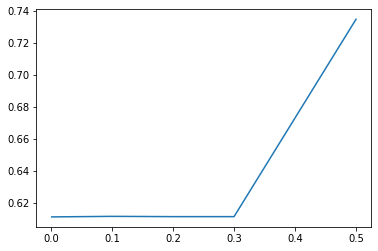

In [84]:
ps = [0.5, 0.3, 0.2, 0.1, 0.005, 0.001]
ss = [p_threshold_to_lr_score(p) for p in ps]
plt.plot(ps,ss)

Maybe some of the factors with higher p-values are actually better predictors..?

In [ ]:
lr = LogisticRegression().fit(train[train.columns[:-1]],train["155"])

In [87]:
lr.coef_

array([[-2.97188982e+00, -2.97188982e+00, -5.70423456e+00,
        -5.70423456e+00, -1.22188121e-01, -1.22188121e-01,
        -1.22188121e-01, -1.22188121e-01, -1.22188121e-01,
        -1.22188121e-01, -1.22188121e-01,  2.03462960e+00,
        -1.22188121e-01, -4.11851068e+00, -1.33828724e-01,
         1.03891618e+00, -1.16110430e+00, -1.22188121e-01,
         4.85871320e+00, -1.22188121e-01, -2.71606819e+00,
        -1.93423606e+00, -4.43167205e+00,  3.45810678e+00,
        -5.12423306e+00,  5.76116444e+00, -2.53150651e+00,
         4.16397375e+00,  6.05664910e-01,  7.85671962e-01,
         2.97773819e+00, -2.51923253e+00, -2.38570489e+00,
        -1.40349367e-01, -1.02270764e+01, -1.10047661e-04,
        -6.62944508e-04, -7.72992169e-04, -6.68604534e-05,
        -1.22188121e-01,  4.56870105e+00, -3.74304433e+00,
        -7.62789765e+00, -3.29112960e-05,  4.57385972e+00,
        -2.57598852e+00, -4.16488299e-04,  1.37102794e-01,
        -1.13304933e+01,  2.77876475e-02, -1.46395677e+0

Could look at size of coefficients as an indicator of importance..? Maybe something to pursue. Or could use random forest to get relative importances.

Looks like some factors are highly correlated, so perhaps PCA or clustering on factors first.

In [90]:
from sklearn.decomposition import PCA

In [92]:
pca = PCA(n_components=20)

In [93]:
pca.fit(train[train.columns[:-1]])

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [94]:
pca.explained_variance_

array([1.02098232, 0.86131361, 0.2540735 , 0.12245628, 0.1020006 ,
       0.06261603, 0.03867685, 0.03298436, 0.02661625, 0.02474394,
       0.02087587, 0.01080953, 0.0084663 , 0.00714234, 0.00627585,
       0.00611999, 0.00459349, 0.0039681 , 0.00341409, 0.00329887])

In [97]:
pca_train = pca.fit_transform(train[train.columns[:-1]])

In [98]:
lr = LogisticRegression().fit(pca_train,train["155"])

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
pca_test = pca.transform(test[test.columns[:-1]])

In [100]:
lr.score(pca_test,test["155"])

0.8595049554260671

Twenty component PCA does relatively well.

Let's look at a few more or fewer components. We can do that by taking say fifty and then keeping the first 5, 10, 20, 50 of them

In [107]:
pca = PCA(n_components=50)

In [101]:
pca_train = pca.fit_transform(train[train.columns[:-1]])
pca_test = pca.transform(test[test.columns[:-1]])

In [104]:
for pcs in [1,5,10,20,50]:
    lr = LogisticRegression(solver='liblinear').fit(pca_train[:,:pcs],train["155"])
    score = lr.score(pca_test[:,:pcs], test["155"])
    print(f"{pcs}:\t{score}")

1:	0.8479007918721052
5:	0.9719358533791523
10:	0.9775885253249664
20:	0.8595049554260671
50:	0.8595049554260671


Looking closer at 1 to 20:

In [108]:
def principalcomponents_lrscore(n):
    lr = LogisticRegression(solver='liblinear').fit(pca_train[:,:n],train["155"])
    score = lr.score(pca_test[:,:n], test["155"])
    return score

In [ ]:
pcs = list(range(1,20))
lrs = [principalcomponents_lrscore(n) for n in pcs]

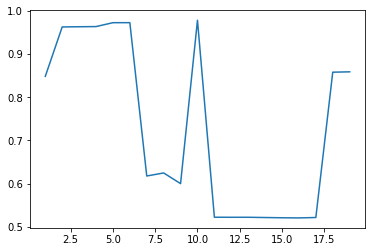

In [109]:
plt.plot(pcs, lrs)

Seems 10 is a good choice of principal components

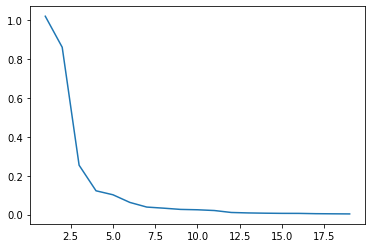

In [113]:
pca = PCA(n_components=19)
pca.fit(train[train.columns[:-1]])
plt.plot(pcs,pca.explained_variance_)